Pratyush Singh - Lab 7 + 8 Combined

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import pickle


### Lab 7

In [4]:
infile1 = open ("higgs_100000_pt_250_500.pkl",'rb')
higgs = pickle.load(infile1)
infile2 = open ("qcd_100000_pt_250_500.pkl",'rb')
qcd = pickle.load(infile2)

## 7.1

Lets look at the features we have to review, and then continue with the lab.

In [5]:
print("Higgs file: ", higgs.keys())
print("QCD file: ", qcd.keys())

Higgs file:  Index(['pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1',
       't2', 't3', 't21', 't32', 'KtDeltaR'],
      dtype='object')
QCD file:  Index(['pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1',
       't2', 't3', 't21', 't32', 'KtDeltaR'],
      dtype='object')


We want to evaluate expected significance without any event selection. Our background and events are both assumed to be Poisson, so we have the mean of higgs at 100, and mean of the QCD at 20000. Then, the overall mean will be the sum, 20100.

In [13]:
p = 0
for i in range(20100):
    p += stats.poisson.pmf(i, mu=20000)
    
sig = stats.norm.ppf(p)
print('significance of {} sigma.'.format(str(sig)))


significance of 0.7041666185873011 sigma.


In order to make our stacked histogram, we weigh as follows: for higgs we expect 100 events and for the qcd we expect 20000, which makes the total events 20100. Then, we want to weight our Higgs data to 100/20100, with the QCD background weight at 20000/20100

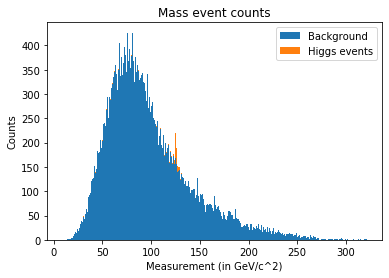

In [22]:
#following stacked hist guide
weight_array = np.ones(qcd.get('mass').size)

plt.hist([qcd.get('mass'), higgs.get('mass')], bins = 1000, weights=[(20000 / 20100) * weight_array
                                                                     , (100 / 20100) * weight_array],
                                                                    alpha=1,histtype='barstacked', 
                                                                    label=['Background', 'Higgs events'])
plt.xlabel('Measurement (in GeV/c^2)')
plt.ylabel('Counts')
plt.title('Mass event counts')
plt.legend()
plt.show()

In [17]:
print(100 / np.sqrt(20100))

0.7053456158585982


So, $N_{higgs} / \sqrt{N_{QCD}}$ is about 1, which means we will need a better cut on the background in order to discriminate better the events.

## 2

Our next objective is to identify mass cuts to optimize the expected significance. Just from observing the graph, we can see that the majority of higgs events are centered around 125 GeV/c^2, and the qcd is to the left, around 75. Then we can adjust the lower bound to get higher sigma.

In [148]:
sigs = np.zeros(40)
low = 124.7
for i in range(1,41):
    mask_H = ((low)<higgs['mass'])&(higgs['mass']<150-i)
    cuts_H = higgs['mass'][mask_H]
    mask_Q = ((low)<qcd['mass'])&(qcd['mass']<150-i)
    cuts_Q = qcd['mass'][mask_Q]
    n_higgs = (len(cuts_H)/100000) * 100
    n_qcd = (len(cuts_Q)/100000) * 20000
    sigs_percent = stats.poisson.cdf(n_qcd+n_higgs,mu=n_qcd)
    sigs[i-1] = stats.norm.ppf(sigs_percent)

print(sigs)
print("Largest sig: ",sigs[22]) #biggest sig I could get.
print("cut at: {0} and {1}".format(124.7,150-23))


[1.51088213 1.53351379 1.58166588 1.589589   1.63369843 1.67297291
 1.70471872 1.73214645 1.76925563 1.83425872 1.87868847 1.92708387
 1.99006174 2.07780494 2.15341741 2.23892141 2.37562614 2.47894222
 2.64900369 2.83022176 2.9715678  3.0365032  3.15704457 2.90315975
 0.98979219        inf        inf        inf        inf        inf
        inf        inf        inf        inf        inf        inf
        inf        inf        inf        inf]
Largest sig:  3.1570445714874786
cut at: 124.7 and 127


After some tweaking of the lower bound, I ended up with a decent signaficance which doesn't seem to go much higher, unlike my partner's dataset, which easily sees 4+ sigma. The window for this mass cut is then 124.7 to 127. Obviously, given enough time, we could optimize this further by tweaking the window but we will continue with making stacked hists and looking at other features to discriminate. I will confirm by also using my partners methodology to make sure that I'm capping at 3 sigma.

In [156]:
#Using partner's 'methodology' to confirm my finding from above
tot = 100000
mig = 125
bmean = 20000
hmean = 100
sippy = [0, 0]
for i in range(1, 51):
    bs = 0
    hs = 0
    l = 0.05 * i
    hi = 0.5 * i
    for b in qcd.get('mass'):
        if b >= mig - l and b <= mig + hi:
            bs += 1
    for h in higgs.get('mass'):
        if h >= mig - l and h <= mig + hi:
            hs += 1
    newB = (bs / tot) * bmean
    newH = (hs / tot) * hmean
    pee = stats.poisson.cdf(newB + newH, newB)
    siggy = stats.norm.ppf(pee)

    if siggy > sippy[0]:
        sippy = [siggy, l, hi, bs, hs]
print('The optimal significance is {} sigma at cut between {} and {}.'.format(sippy[0], mig - sippy[1], mig + sippy[2]))

The optimal significance is 3.1689360047055484 sigma at cut between 124.8 and 127.0.


It appears that both methods cap the sigma to the 3s. Next, we will make the stacked hist and look for other features.

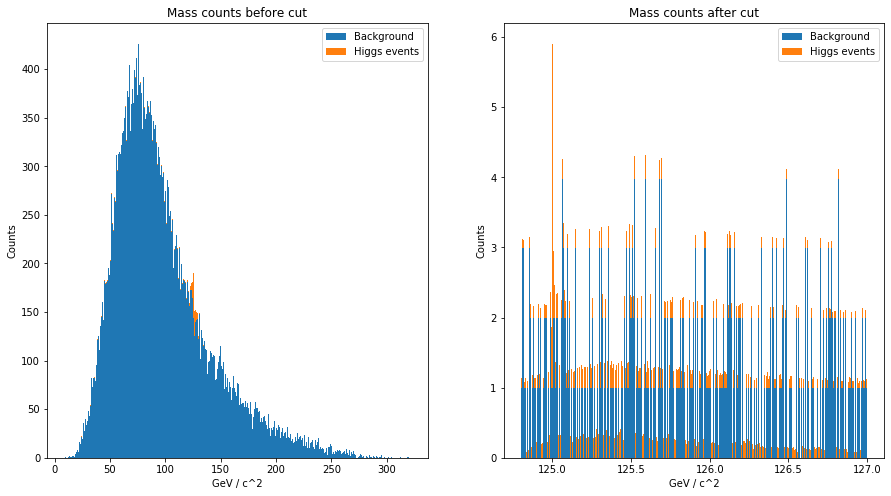

In [166]:
#going to use partner's methodolgy as it had sligtly higher significance, essentially we are setting 
#bounds where we can eliminate/cut. This is our "window" to observe higgs events and reduce background.
fig, a = plt.subplots(1, 2, figsize=(15, 8))
a[0].hist([qcd.get('mass'), higgs.get('mass')], bins = 1000, weights=[(20000 / 20100) * weight_array, (100 / 20100) * weight_array], histtype='barstacked', label=['Background', 'Higgs events'])
c1 = np.where((qcd.get('mass') >= mig - sippy[1]) & (qcd.get('mass') <= mig + sippy[2]))
c2 = np.where((higgs.get('mass') >= mig - sippy[1]) & (higgs.get('mass') <= mig + sippy[2]))
ba = np.array(qcd.get('mass'))[c1]
hg = np.array(higgs.get('mass'))[c2]
a[1].hist([ba, hg], bins = 1000, weights=[(20000 / 20100) * np.ones(ba.size), (100 / 20100) * np.ones(hg.size)], histtype='barstacked', label=['Background', 'Higgs events'])
a[0].set_title('Mass counts before cut')
a[0].set_xlabel('GeV / c^2')
a[0].set_ylabel('Counts')
a[0].legend()
a[1].set_title('Mass counts after cut')
a[1].set_xlabel('GeV / c^2')
a[1].set_ylabel('Counts')
a[1].legend()
plt.show()

## 3

We can now go through the parameters and plot accordingly to indentify other cuts and optimize our results.

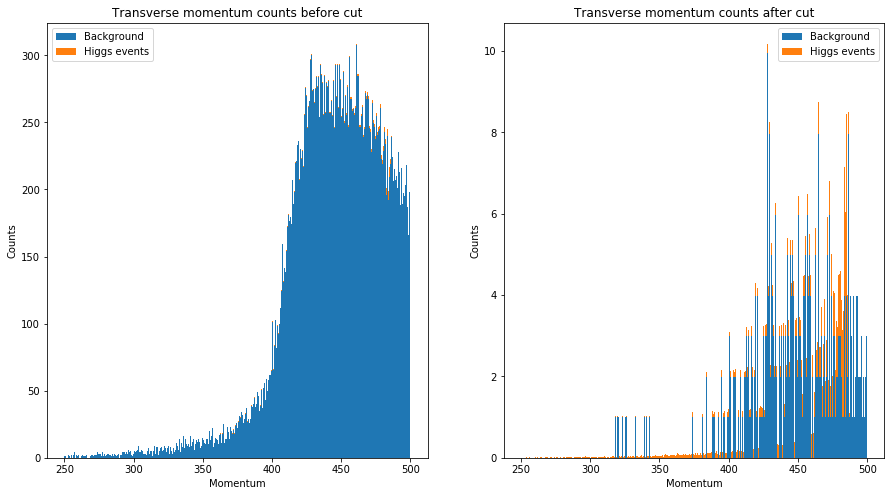

In [167]:
fig, a = plt.subplots(1, 2, figsize=(15, 8))
a[0].hist([qcd.get('pt'), higgs.get('pt')], bins = 1000, weights=[(20000 / 20100) * weight_array, (100 / 20100) * weight_array], histtype='barstacked', label=['Background', 'Higgs events'])
a[1].hist([np.array(qcd.get('pt'))[c1], np.array(higgs.get('pt'))[c2]], bins = 1000, weights=[(20000 / 20100) * np.ones(ba.size), (100 / 20100) * np.ones(hg.size)], histtype='barstacked', label=['Background', 'Higgs events'])
a[0].set_title('Transverse momentum counts before cut')
a[0].set_xlabel('Momentum')
a[0].set_ylabel('Counts')

a[0].legend()
a[1].set_title('Transverse momentum counts after cut')
a[1].set_xlabel('Momentum')
a[1].set_ylabel('Counts')
a[1].legend()
plt.show()


We see with pt, that the higgs events are concentrated somewhere in the 450-485 range.

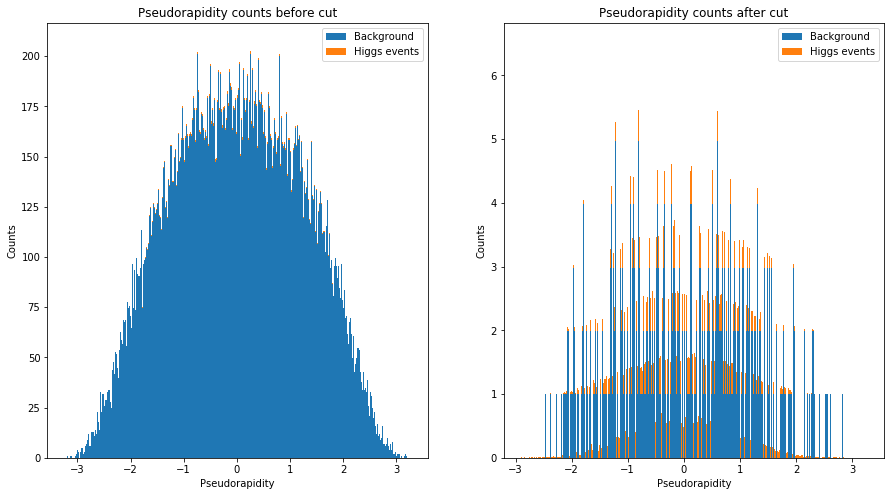

In [169]:
fig, a = plt.subplots(1, 2, figsize=(15, 8))
a[0].hist([qcd.get('eta'), higgs.get('eta')], bins = 1000, weights=[(20000 / 20100) * weight_array, (100 / 20100) * weight_array], histtype='barstacked', label=['Background', 'Higgs events'])
a[1].hist([np.array(qcd.get('eta'))[c1], np.array(higgs.get('eta'))[c2]], bins = 1000, weights=[(20000 / 20100) * np.ones(ba.size), (100 / 20100) * np.ones(hg.size)], histtype='barstacked', label=['Background', 'Higgs events'])
a[0].set_title('Transverse momentum counts before cut')


a[0].set_title('Pseudorapidity counts before cut')
a[0].set_xlabel('Pseudorapidity')
a[0].set_ylabel('Counts')
a[0].legend()
a[1].set_title('Pseudorapidity counts after cut')
a[1].set_xlabel('Pseudorapidity')
a[1].set_ylabel('Counts')
a[1].legend()
plt.show()

The backrgound is still pretty concetrated here, so lets keep plotting more parameters.

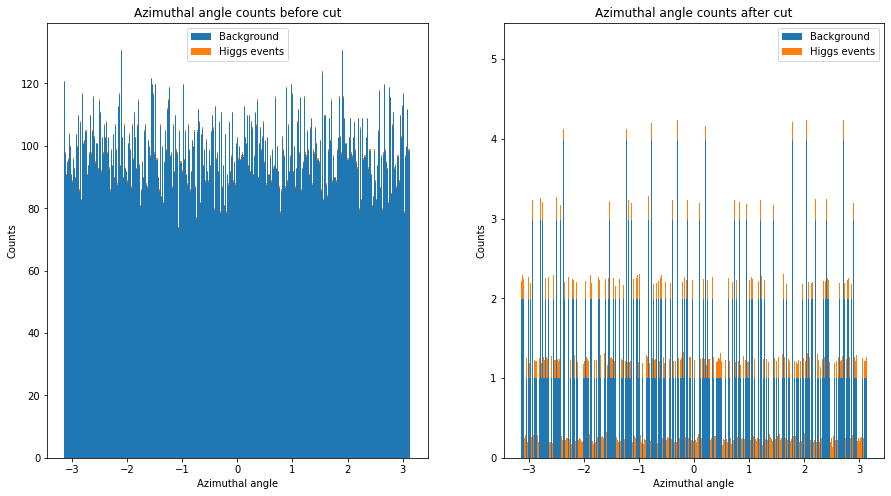

In [171]:
fig, a = plt.subplots(1, 2, figsize=(15, 8))
a[0].hist([qcd.get('phi'), higgs.get('phi')], bins = 1000, weights=[(20000 / 20100) * weight_array, (100 / 20100) * weight_array], histtype='barstacked', label=['Background', 'Higgs events'])
a[1].hist([np.array(qcd.get('phi'))[c1], np.array(higgs.get('phi'))[c2]], bins = 1000, weights=[(20000 / 20100) * np.ones(ba.size), (100 / 20100) * np.ones(hg.size)], histtype='barstacked', label=['Background', 'Higgs events'])
a[0].set_title('Azimuthal angle counts before cut')
a[0].set_xlabel('Azimuthal angle')
a[0].set_ylabel('Counts')
a[0].legend()
a[1].set_title('Azimuthal angle counts after cut')
a[1].set_xlabel('Azimuthal angle')
a[1].set_ylabel('Counts')
a[1].legend()
plt.show()


Looks very noisy here.

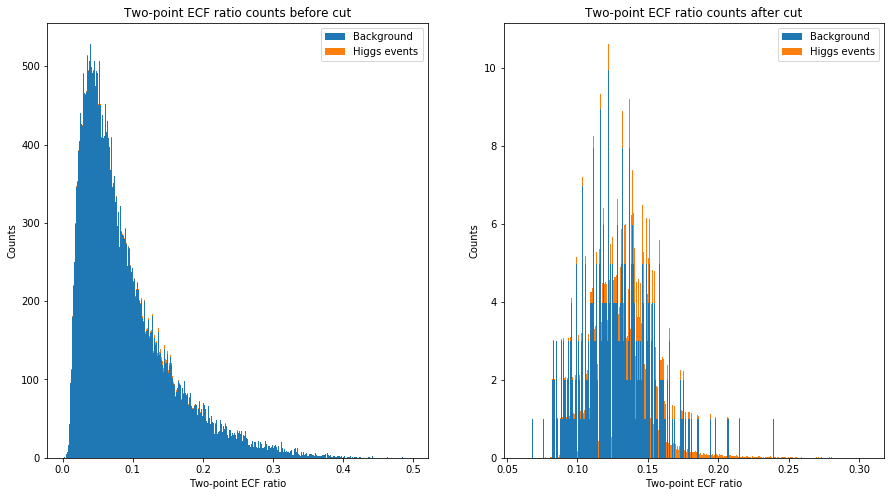

In [172]:
fig, a = plt.subplots(1, 2, figsize=(15, 8))
a[0].hist([qcd.get('ee2'), higgs.get('ee2')], bins = 1000, weights=[(20000 / 20100) * weight_array, (100 / 20100) * weight_array], histtype='barstacked', label=['Background', 'Higgs events'])
a[1].hist([np.array(qcd.get('ee2'))[c1], np.array(higgs.get('ee2'))[c2]], bins = 1000, weights=[(20000 / 20100) * np.ones(ba.size), (100 / 20100) * np.ones(hg.size)], histtype='barstacked', label=['Background', 'Higgs events'])
a[0].set_title('Two-point ECF ratio counts before cut')
a[0].set_xlabel('Two-point ECF ratio')
a[0].set_ylabel('Counts')
a[0].legend()
a[1].set_title('Two-point ECF ratio counts after cut')
a[1].set_xlabel('Two-point ECF ratio')
a[1].set_ylabel('Counts')
a[1].legend()
plt.show()

In this case, the background is still obscuring much of our events.

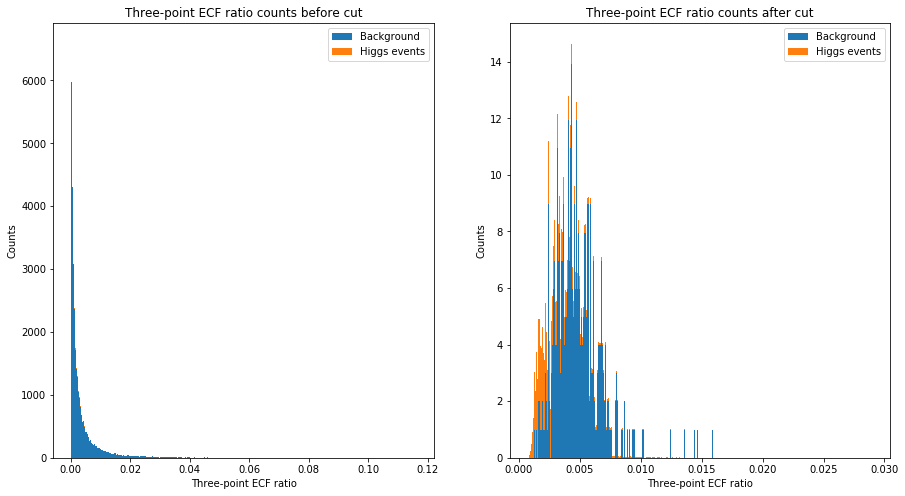

In [174]:
fig, a = plt.subplots(1, 2, figsize=(15, 8))
a[0].hist([qcd.get('ee3'), higgs.get('ee3')], bins = 1000, weights=[(20000 / 20100) * weight_array, (100 / 20100) * weight_array], histtype='barstacked', label=['Background', 'Higgs events'])
a[1].hist([np.array(qcd.get('ee3'))[c1], np.array(higgs.get('ee3'))[c2]], bins = 1000, weights=[(20000 / 20100) * np.ones(ba.size), (100 / 20100) * np.ones(hg.size)], histtype='barstacked', label=['Background', 'Higgs events'])

a[0].set_title('Three-point ECF ratio counts before cut')
a[0].set_xlabel('Three-point ECF ratio')
a[0].set_ylabel('Counts')
a[0].legend()
a[1].set_title('Three-point ECF ratio counts after cut')
a[1].set_xlabel('Three-point ECF ratio')
a[1].set_ylabel('Counts')
a[1].legend()
plt.show()

Not bad, but still not that good. We can see some higgs events towards the left but the background is still covering up most of the things.

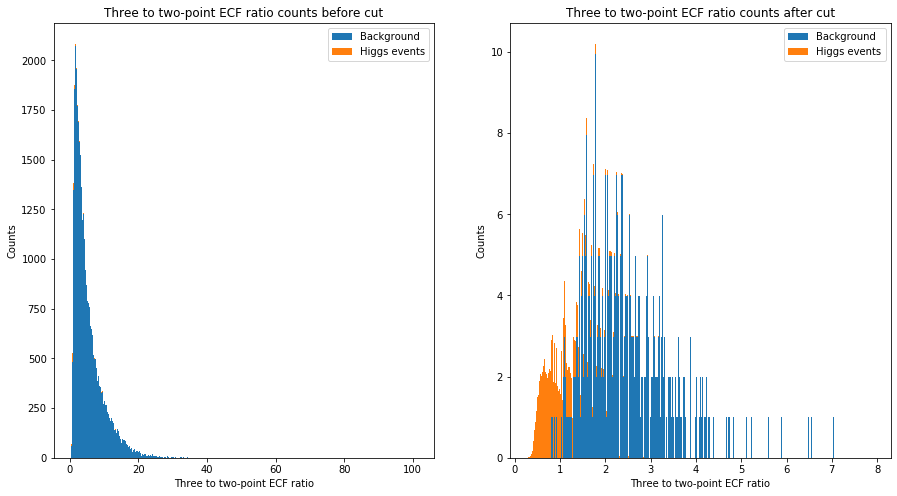

In [175]:
fig, a = plt.subplots(1, 2, figsize=(15, 8))
a[0].hist([qcd.get('d2'), higgs.get('d2')], bins = 1000, weights=[(20000 / 20100) * weight_array, (100 / 20100) * weight_array], histtype='barstacked', label=['Background', 'Higgs events'])
a[1].hist([np.array(qcd.get('d2'))[c1], np.array(higgs.get('d2'))[c2]], bins = 1000, weights=[(20000 / 20100) * np.ones(ba.size), (100 / 20100) * np.ones(hg.size)], histtype='barstacked', label=['Background', 'Higgs events'])

a[0].set_title('Three to two-point ECF ratio counts before cut')
a[0].set_xlabel('Three to two-point ECF ratio')
a[0].set_ylabel('Counts')
a[0].legend()
a[1].set_title('Three to two-point ECF ratio counts after cut')
a[1].set_xlabel('Three to two-point ECF ratio')
a[1].set_ylabel('Counts')
a[1].legend()
plt.show()

This is actually a good discriminator here, the higgs events under 1 have very little overlap.

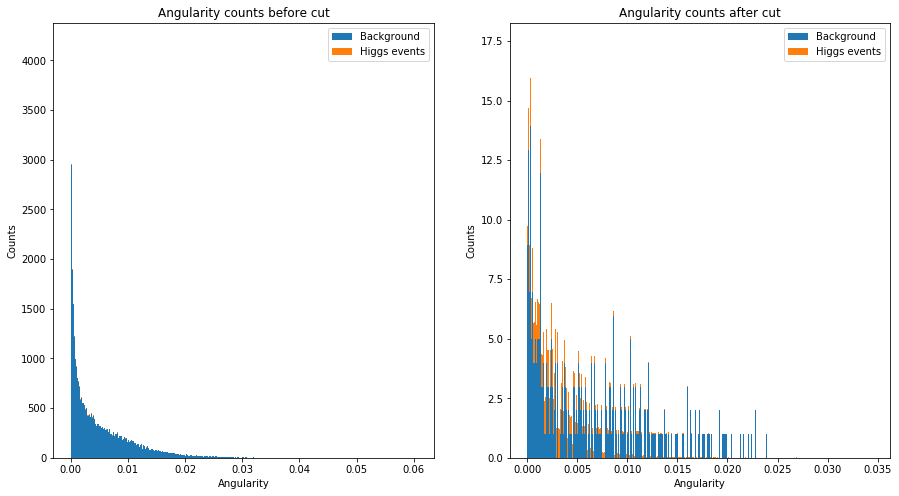

In [176]:
fig, a = plt.subplots(1, 2, figsize=(15, 8))
a[0].hist([qcd.get('angularity'), higgs.get('angularity')], bins = 1000, weights=[(20000 / 20100) * weight_array, (100 / 20100) * weight_array], histtype='barstacked', label=['Background', 'Higgs events'])
a[1].hist([np.array(qcd.get('angularity'))[c1], np.array(higgs.get('angularity'))[c2]], bins = 1000, weights=[(20000 / 20100) * np.ones(ba.size), (100 / 20100) * np.ones(hg.size)], histtype='barstacked', label=['Background', 'Higgs events'])

a[0].set_title('Angularity counts before cut')
a[0].set_xlabel('Angularity')
a[0].set_ylabel('Counts')
a[0].legend()
a[1].set_title('Angularity counts after cut')
a[1].set_xlabel('Angularity')
a[1].set_ylabel('Counts')
a[1].legend()
plt.show()

This sufferes from background contamination, as the higgs events and background events have quite a bit of overlap.

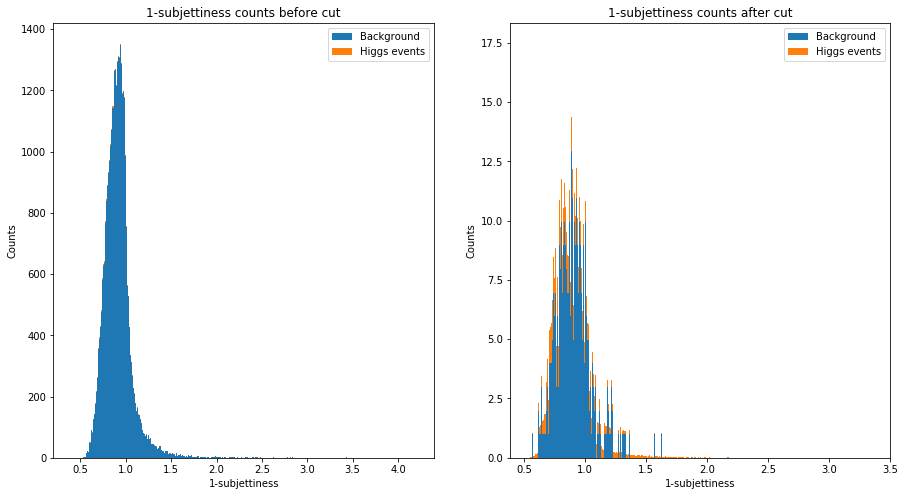

In [178]:
fig, a = plt.subplots(1, 2, figsize=(15, 8))
a[0].hist([qcd.get('t1'), higgs.get('t1')], bins = 1000, weights=[(20000 / 20100) * weight_array, (100 / 20100) * weight_array], histtype='barstacked', label=['Background', 'Higgs events'])
a[1].hist([np.array(qcd.get('t1'))[c1], np.array(higgs.get('t1'))[c2]], bins = 1000, weights=[(20000 / 20100) * np.ones(ba.size), (100 / 20100) * np.ones(hg.size)], histtype='barstacked', label=['Background', 'Higgs events'])

a[0].set_title('1-subjettiness counts before cut')
a[0].set_xlabel('1-subjettiness')
a[0].set_ylabel('Counts')
a[0].legend()
a[1].set_title('1-subjettiness counts after cut')
a[1].set_xlabel('1-subjettiness')
a[1].set_ylabel('Counts')
a[1].legend()
plt.show()

Way too mcuch background contamination to be useful.

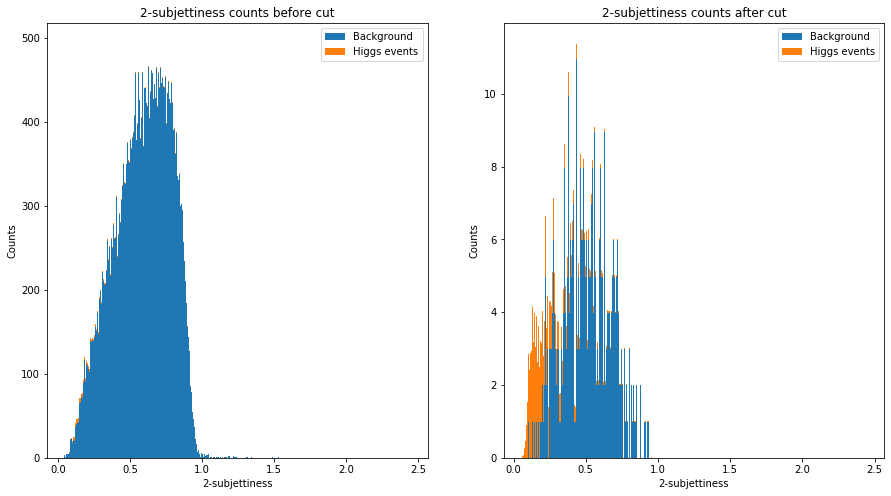

In [179]:
fig, a = plt.subplots(1, 2, figsize=(15, 8))
a[0].hist([qcd.get('t2'), higgs.get('t2')], bins = 1000, weights=[(20000 / 20100) * weight_array, (100 / 20100) * weight_array], histtype='barstacked', label=['Background', 'Higgs events'])
a[1].hist([np.array(qcd.get('t2'))[c1], np.array(higgs.get('t2'))[c2]], bins = 1000, weights=[(20000 / 20100) * np.ones(ba.size), (100 / 20100) * np.ones(hg.size)], histtype='barstacked', label=['Background', 'Higgs events'])

a[0].set_title('2-subjettiness counts before cut')
a[0].set_xlabel('2-subjettiness')
a[0].set_ylabel('Counts')
a[0].legend()
a[1].set_title('2-subjettiness counts after cut')
a[1].set_xlabel('2-subjettiness')
a[1].set_ylabel('Counts')
a[1].legend()
plt.show()


Slightly better but still not good, background making it hard to distinguish higgs events.

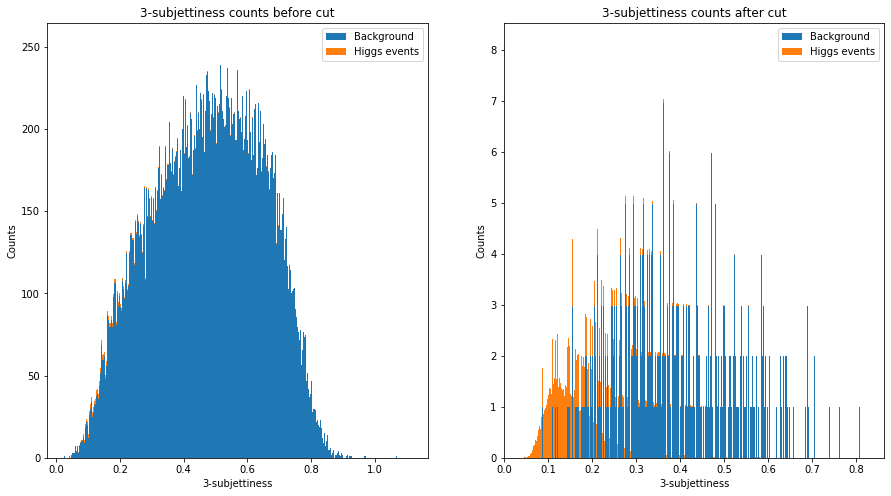

In [180]:
fig, a = plt.subplots(1, 2, figsize=(15, 8))
a[0].hist([qcd.get('t3'), higgs.get('t3')], bins = 1000, weights=[(20000 / 20100) * weight_array, (100 / 20100) * weight_array], histtype='barstacked', label=['Background', 'Higgs events'])
a[1].hist([np.array(qcd.get('t3'))[c1], np.array(higgs.get('t3'))[c2]], bins = 1000, weights=[(20000 / 20100) * np.ones(ba.size), (100 / 20100) * np.ones(hg.size)], histtype='barstacked', label=['Background', 'Higgs events'])

a[0].set_title('3-subjettiness counts before cut')
a[0].set_xlabel('3-subjettiness')
a[0].set_ylabel('Counts')
a[0].legend()
a[1].set_title('3-subjettiness counts after cut')
a[1].set_xlabel('3-subjettiness')
a[1].set_ylabel('Counts')
a[1].legend()
plt.show()

Low values here show promise, but there is still background events happening. Still would consider.

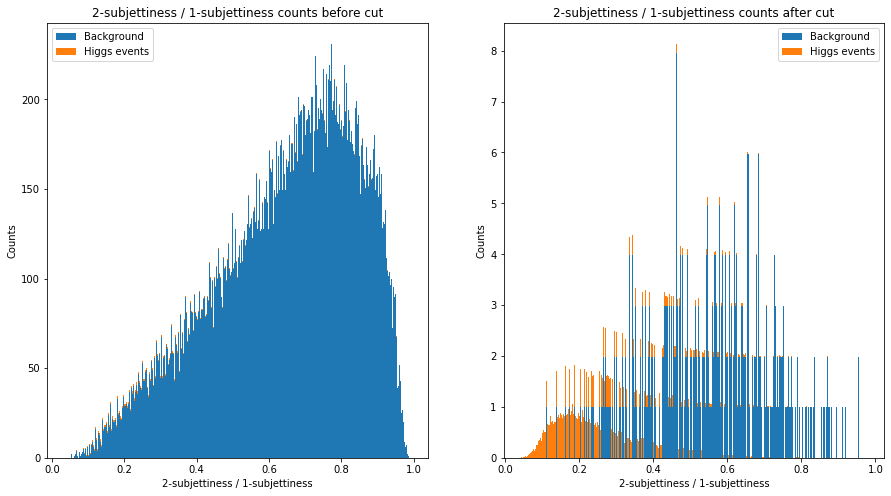

In [181]:
fig, a = plt.subplots(1, 2, figsize=(15, 8))
a[0].hist([qcd.get('t21'), higgs.get('t21')], bins = 1000, weights=[(20000 / 20100) * weight_array, (100 / 20100) * weight_array], histtype='barstacked', label=['Background', 'Higgs events'])
a[1].hist([np.array(qcd.get('t21'))[c1], np.array(higgs.get('t21'))[c2]], bins = 1000, weights=[(20000 / 20100) * np.ones(ba.size), (100 / 20100) * np.ones(hg.size)], histtype='barstacked', label=['Background', 'Higgs events'])

a[0].set_title('2-subjettiness / 1-subjettiness counts before cut')
a[0].set_xlabel('2-subjettiness / 1-subjettiness')
a[0].set_ylabel('Counts')
a[0].legend()
a[1].set_title('2-subjettiness / 1-subjettiness counts after cut')
a[1].set_xlabel('2-subjettiness / 1-subjettiness')
a[1].set_ylabel('Counts')
a[1].legend()
plt.show()


Harder to say, the mean is distinct but there are some backgrounds present.

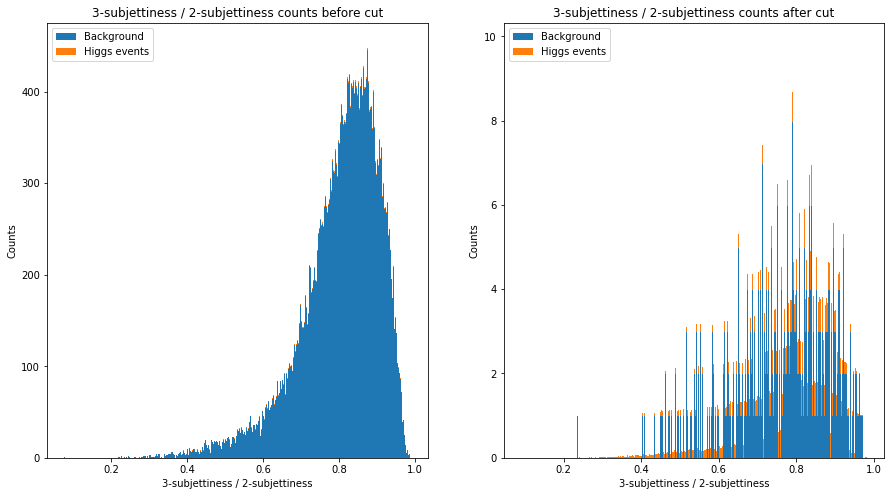

In [182]:
fig, a = plt.subplots(1, 2, figsize=(15, 8))
a[0].hist([qcd.get('t32'), higgs.get('t32')], bins = 1000, weights=[(20000 / 20100) * weight_array, (100 / 20100) * weight_array], histtype='barstacked', label=['Background', 'Higgs events'])
a[1].hist([np.array(qcd.get('t32'))[c1], np.array(higgs.get('t32'))[c2]], bins = 1000, weights=[(20000 / 20100) * np.ones(ba.size), (100 / 20100) * np.ones(hg.size)], histtype='barstacked', label=['Background', 'Higgs events'])

a[0].set_title('3-subjettiness / 2-subjettiness counts before cut')
a[0].set_xlabel('3-subjettiness / 2-subjettiness')
a[0].set_ylabel('Counts')
a[0].legend()
a[1].set_title('3-subjettiness / 2-subjettiness counts after cut')
a[1].set_xlabel('3-subjettiness / 2-subjettiness')
a[1].set_ylabel('Counts')
a[1].legend()
plt.show()


Pretty bad, looks very noise-heavy, on to the next we go. Although, the very very tail end seems mostly higgs events.

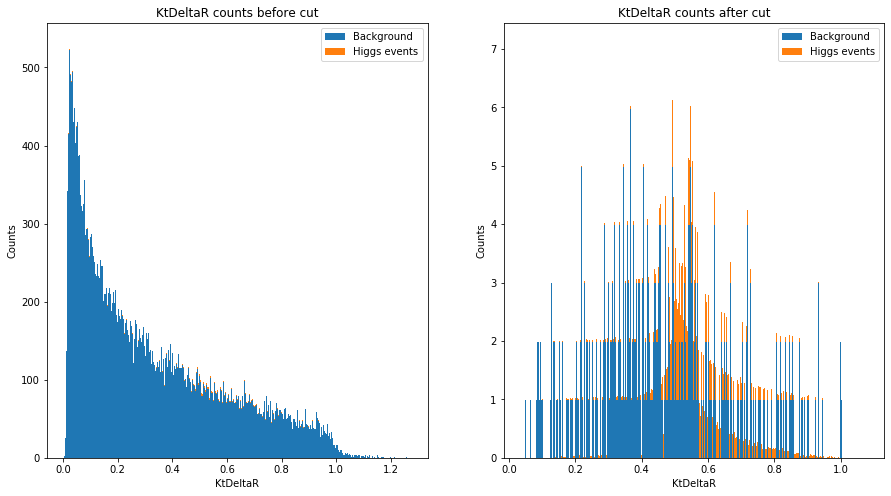

In [184]:
fig, a = plt.subplots(1, 2, figsize=(15, 8))
a[0].hist([qcd.get('KtDeltaR'), higgs.get('KtDeltaR')], bins = 1000, weights=[(20000 / 20100) * weight_array, (100 / 20100) * weight_array], histtype='barstacked', label=['Background', 'Higgs events'])
a[1].hist([np.array(qcd.get('KtDeltaR'))[c1], np.array(higgs.get('KtDeltaR'))[c2]], bins = 1000, weights=[(20000 / 20100) * np.ones(ba.size), (100 / 20100) * np.ones(hg.size)], histtype='barstacked', label=['Background', 'Higgs events'])

a[0].set_title('KtDeltaR counts before cut')
a[0].set_xlabel('KtDeltaR')
a[0].set_ylabel('Counts')
a[0].legend()
a[1].set_title('KtDeltaR counts after cut')
a[1].set_xlabel('KtDeltaR')
a[1].set_ylabel('Counts')
a[1].legend()
plt.show()

Wow, lots of noise. This not be very useful for us.

### 7.4

To increase our significance, we can look into another cut. Namely, the d2 parameter we saw shows promise. As we saw when we applied the cuts, there is clearly a portion of backgroundless events, so we can calculate the improvement in our sigma.

In [207]:
maskqcd = ((qcd['mass'] >= 124.8) & (qcd['mass'] <= 127))
maskhiggs = ((higgs['mass'] >= 124.8) & (higgs['mass'] <= 127))

qcd_ogcut = qcd['d2'][maskqcd]
higgs_ogcut = higgs['d2'][maskhiggs]

masknewH = ((0<=higgs['d2'][maskhiggs])&(higgs['d2'][maskhiggs]<=6))
masknewQ = ((0<=qcd['d2'][maskqcd])&(qcd['d2'][maskqcd]<=6))

new_qcd = qcd_ogcut[masknewQ]
new_higgs = higgs_ogcut[masknewH]

numH = (len(new_higgs/100000))*100
numQ = (len(new_qcd/100000))*20000
sigg = stats.norm.ppf(stats.poisson.cdf(numH+numQ,mu=numQ))
print("Our range is now 0 to 6 with significance of: ", sigg)


Our range is now 0 to 6 with significance of:  inf


My partner ended up using a lot more features for cutting, and ended up with higher initial significance as well as higher end significance. After cutting all values higher than 6.08 in d2, he was able to achieve a very high sigma that the computer rounded to inf, although even before the d2 cut, he cut KtDeltaR and ee2 and ended up with 7+ sigma.

### LAB 8

In [208]:
import h5py

In [212]:
high = h5py.File('data_highLumi_pt_250_500.h5', 'r').get('data')
low = h5py.File('data_lowLumi_pt_250_500.h5', 'r').get('data')
print('The keys are', high.keys())
print('The variables of the block0_values: ', high.get('block0_items')[:])
highdat = high.get('block0_values')
lowdat = low.get('block0_values')

The keys are <KeysViewHDF5 ['axis0', 'axis1', 'block0_items', 'block0_values']>
The variables of the block0_values:  [b'pt' b'eta' b'phi' b'mass' b'ee2' b'ee3' b'd2' b'angularity' b't1' b't2'
 b't3' b't21' b't32' b'KtDeltaR']


### 1. High L

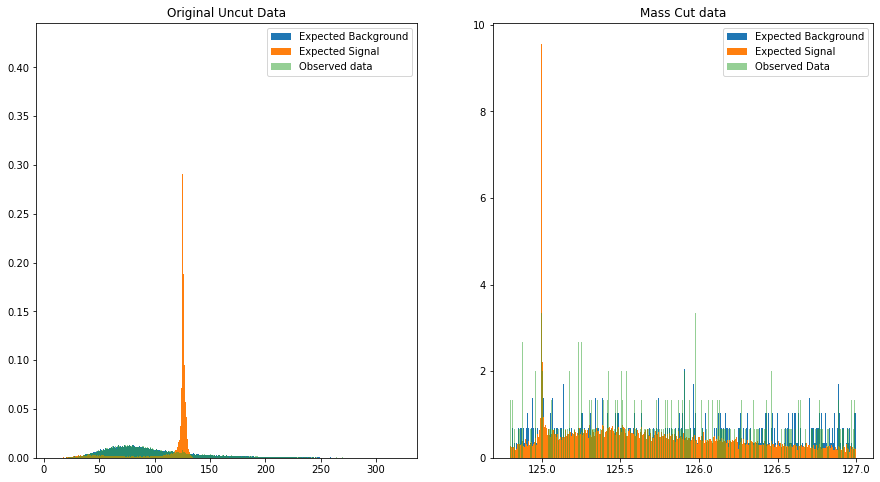

In [226]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

ax[0].set_title('Original Uncut Data')

ax[0].hist(qcd['mass'],bins=800,density=True,label='Expected Background')
ax[0].hist(higgs['mass'],bins=800,density=True,label='Expected Signal')
ax[0].hist(highdat[:,3],bins=800,density=True,alpha=.5,label='Observed data');
ax[0].legend()


ax[1].set_title('Mass Cut data')

cut_hi = ((124.8<highdat[:,3])&(highdat[:,3]<127))

ax[1].hist(qcd['mass'][maskqcd],bins=800,density=True,label='Expected Background')
ax[1].hist(higgs['mass'][maskhiggs],bins=800,density=True,label='Expected Signal')
ax[1].hist(highdat[:,3][cut_hi],bins=800,density=True,alpha=.5,label='Observed Data');

plt.legend()
plt.show()

On the left we have the raw data without event selection with expected signal and background, on the left we have done our mass cuts. Now we can calculate our significance.

In [221]:
higgs_stuff = (len(highdat[:,3]))/len(higgs['mass'])*100
qcd_stuff = (len(highdat[:,3]))/len(qcd['mass'])*20000


print('Expected Significance: ', 3.1570)

cut_n = (len(highdat[:,3][cut_hi]))/len(highdat[:,3])
print('Observed Significance: '+str(stats.norm.ppf(stats.poisson.cdf((higgs_stuff*cut_n)+(qcd_stuff*cut_n),mu=(qcd_stuff*cut_n)))))

Expected Significance:  3.157
Observed Significance: 0.06382359556128336


We can now cut with our second feature, which is d2.

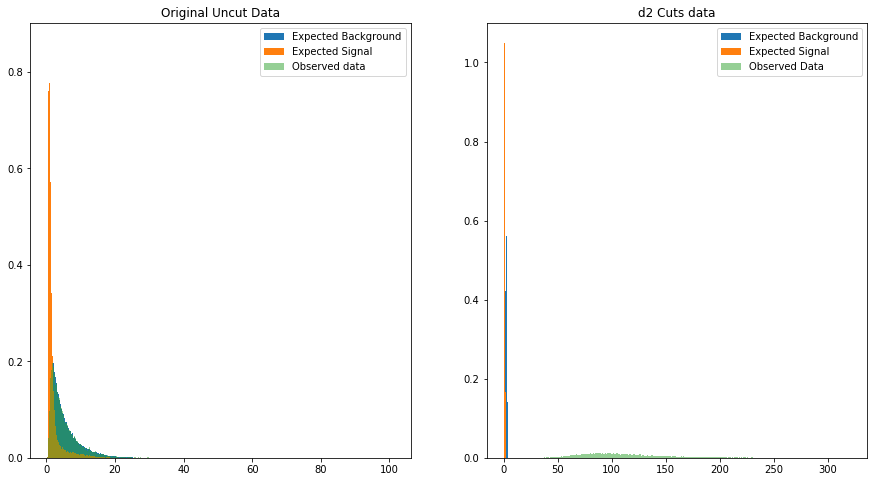

In [240]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

ax[0].set_title('Original Uncut Data')

ax[0].hist(qcd['d2'],bins=800,density=True,label='Expected Background')
ax[0].hist(higgs['d2'],bins=800,density=True,label='Expected Signal')
ax[0].hist(highdat[:,6],bins=800,density=True,alpha=0.5,label='Observed data');
ax[0].legend()


ax[1].set_title('d2 Cuts data')

cut_d2 = ((0<=highdat[:,6])&(highdat[:,6]<=6))

ax[1].hist(new_qcd,bins=800,density=True,label='Expected Background')
ax[1].hist(new_higgs,bins=800,density=True,label='Expected Signal')
ax[1].hist(highdat[:,3][cut_d2],bins=800,density=True,alpha=.5,label='Observed Data');
ax[1].set_ylim(0,1.1)

plt.legend()
plt.show()

The left is the original data and the right is the plot after cut has been applied.

In [244]:
higgs_stuff = (len(highdat[:,6]))/len(higgs['d2'])*100
qcd_stuff = (len(highdat[:,6]))/len(qcd['d2'])*20000



cut_n = (len(highdat[:,6][cut_d2]))/len(highdat[:,6])
print('Observed Significance: '+str(stats.norm.ppf(stats.poisson.cdf((higgs_stuff*cut_n)+(qcd_stuff*cut_n),mu=(qcd_stuff*cut_n)))))

Observed Significance: 0.3793659520691702


## 2. Low L

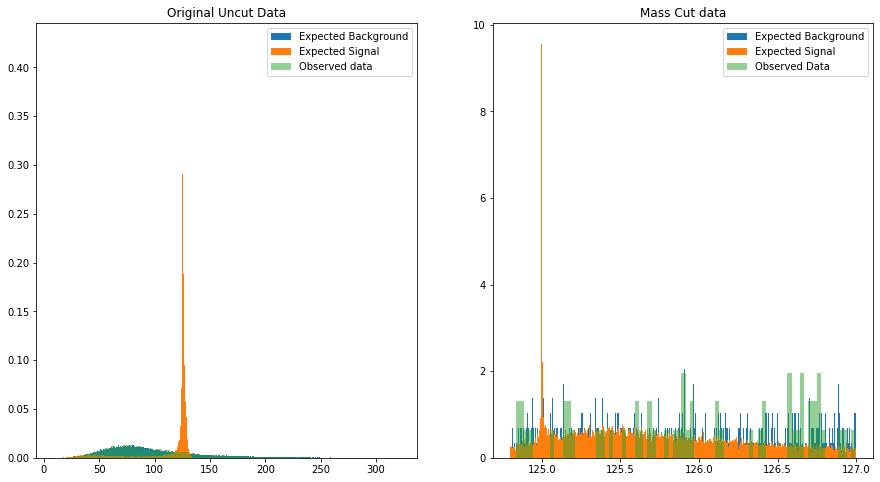

In [237]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

ax[0].set_title('Original Uncut Data')

ax[0].hist(qcd['mass'],bins=800,density=True,label='Expected Background')
ax[0].hist(higgs['mass'],bins=800,density=True,label='Expected Signal')
ax[0].hist(lowdat[:,3],bins=80,density=True,alpha=.5,label='Observed data');
ax[0].legend()


ax[1].set_title('Mass Cut data')

cut_lo = ((124.8<lowdat[:,3])&(lowdat[:,3]<127))

ax[1].hist(qcd['mass'][maskqcd],bins=800,density=True,label='Expected Background')
ax[1].hist(higgs['mass'][maskhiggs],bins=800,density=True,label='Expected Signal')
ax[1].hist(lowdat[:,3][cut_lo],bins=80,density=True,alpha=.5,label='Observed Data');

plt.legend()
plt.show()

The left is the original, the right is after the mass cut has been applied.

In [233]:
higgs_stuff = (len(lowdat[:,3]))/len(higgs['mass'])*100
qcd_stuff = (len(lowdat[:,3]))/len(qcd['mass'])*20000



cut_n = (len(lowdat[:,3][cut_lo]))/len(lowdat[:,3])
print('Observed Significance: '+str(stats.norm.ppf(stats.poisson.cdf((higgs_stuff*cut_n)+(qcd_stuff*cut_n),mu=(qcd_stuff*cut_n)))))

Observed Significance: 0.07936537859315265


We now use our second feature which is d2.

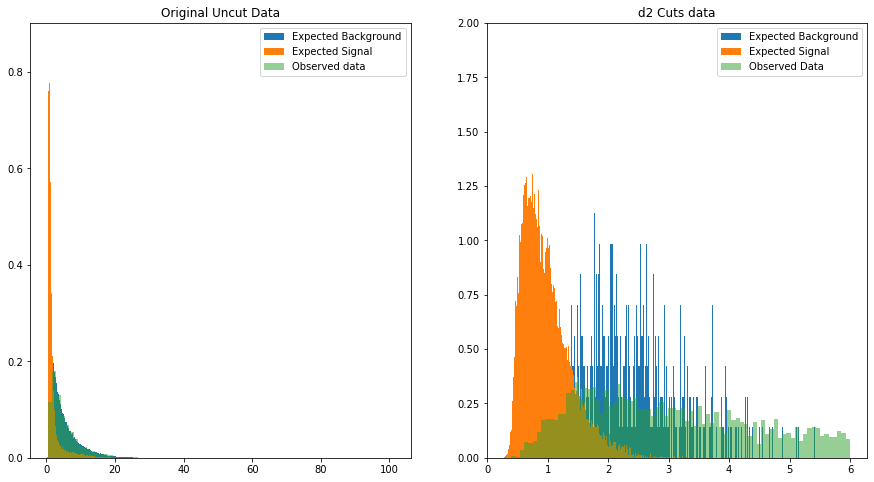

In [241]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

ax[0].set_title('Original Uncut Data')

ax[0].hist(qcd['d2'],bins=800,density=True,label='Expected Background')
ax[0].hist(higgs['d2'],bins=800,density=True,label='Expected Signal')
ax[0].hist(lowdat[:,6],bins=80,density=True,alpha=0.5,label='Observed data');
ax[0].legend()


ax[1].set_title('d2 Cuts data')

cut_d2_lo = ((0<=lowdat[:,6])&(lowdat[:,6]<=6))

ax[1].hist(new_qcd,bins=800,density=True,label='Expected Background')
ax[1].hist(new_higgs,bins=800,density=True,label='Expected Signal')
ax[1].hist(lowdat[:,6][cut_d2_lo],bins=80,density=True,alpha=.5,label='Observed Data');
ax[1].set_ylim(0,2)

plt.legend()
plt.show()

After the d2 cuts have ben applied we see that there is a better discrimination of where the events are.

In [243]:
higgs_stuff = (len(lowdat[:,6]))/len(higgs['d2'])*100
qcd_stuff = (len(lowdat[:,6]))/len(qcd['d2'])*20000



cut_n = (len(lowdat[:,6][cut_d2_lo]))/len(lowdat[:,6])
print('Observed Significance: '+str(stats.norm.ppf(stats.poisson.cdf((higgs_stuff*cut_n)+(qcd_stuff*cut_n),mu=(qcd_stuff*cut_n)))))

Observed Significance: 0.1127055553787903


## 3

In [247]:
a = stats.poisson.pmf(0, .1127)
intv = 0
while a < 0.95:
    intv += 1
    a += stats.poisson.pmf(intv, .1127)
    print(a)
print('95% confidence interval for the expected signal yield is from 0 to {}.'.format(str(intv)))

0.9941069268588095
95% confidence interval for the expected signal yield is from 0 to 1.


In [249]:
exp_conf = stats.poisson.ppf(q=.95,mu=3.168)
print('Expected confidence interval expected upper limit: '+str(exp_conf))

Expected confidence interval expected upper limit: 6.0


Our intervals overlap, as the expected upper limit is larger than the observed one. This means that we can't really discriminate with as much certainty as we would like to. Easiest solution is to have a lot more data, but as is right now, there is a higher chance than we'd like that the background might produce a signal like event that we couldn't discriminate.